# Using Predictive Analytics to Predict Delays in Maritime Container Shipping

In [18]:
%matplotlib inline

**Import Libraries**

In [19]:
import csv
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import pylab 
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

import Levenshtein

#http://pythondata.com/dask-large-csv-python/
#import dask.dataframe as dd
 
#from collections import Counter
#from patsy import dmatrices
#import statsmodels.api as sm

#https://www.dataquest.io/blog/pandas-big-data/

**Read in file**

In [20]:
df = pd.read_pickle('2014_data.pkl')

In [4]:
#check that all rows imported
df.shape

(10816209, 24)

In [5]:
#check datatypes
df.dtypes

identifier                             uint64
trade_update_date              datetime64[ns]
run_date                       datetime64[ns]
vessel_name                          category
port_of_unlading                     category
estimated_arrival_date         datetime64[ns]
foreign_port_of_lading               category
record_status_indicator              category
place_of_receipt                     category
port_of_destination                  category
foreign_port_of_destination          category
actual_arrival_date            datetime64[ns]
consignee_name                       category
shipper_party_name                   category
container_number                     category
description_sequence_number            uint64
piece_count                            uint64
description_text                     category
carrier                              category
day_of_week_est                         uint8
day_of_week_act                         uint8
month_est                         

In [6]:
df.head()

,identifier,trade_update_date,run_date,vessel_name,port_of_unlading,estimated_arrival_date,foreign_port_of_lading,record_status_indicator,place_of_receipt,port_of_destination,...,container_number,description_sequence_number,piece_count,description_text,carrier,day_of_week_est,day_of_week_act,month_est,month_act,delay_days
0,2014082158845,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,...,TGHU8036820,1,7881,IKEA HOME FURNISHING PRODUCTS TARIFF NUMBER 44...,HYUNDAI,3,1,8,8,5
1,2014082158905,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,...,APZU3172532,1,80,KLA-GARD PACKED ON 60 PALLETS -DRILLING MUD AD...,HYUNDAI,3,1,8,8,5
2,2014082158905,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,...,APZU3599329,1,80,KLA-GARD PACKED ON 60 PALLETS -DRILLING MUD AD...,HYUNDAI,3,1,8,8,5
3,2014082158905,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,...,TRLU3176120,1,80,KLA-GARD PACKED ON 60 PALLETS -DRILLING MUD AD...,HYUNDAI,3,1,8,8,5
4,2014082158983,2014-08-06,2014-08-21,OOCL SHENZHEN,"Long Beach, California",2014-08-19,"Yantian,China (Mainland)",New,"YANTIAN,CHINA",NaN,...,OOLU1064780,1,498,P.O.NO.050803/050938/051058/051197/051345/051 ...,OOCL,1,2,8,8,1


In [7]:
list(df)

['identifier',
 'trade_update_date',
 'run_date',
 'vessel_name',
 'port_of_unlading',
 'estimated_arrival_date',
 'foreign_port_of_lading',
 'record_status_indicator',
 'place_of_receipt',
 'port_of_destination',
 'foreign_port_of_destination',
 'actual_arrival_date',
 'consignee_name',
 'shipper_party_name',
 'container_number',
 'description_sequence_number',
 'piece_count',
 'description_text',
 'carrier',
 'day_of_week_est',
 'day_of_week_act',
 'month_est',
 'month_act',
 'delay_days']

** Get all vessels for the Port of Los Angeles and Port of Long Beach **   
These will be considered one port for the purpose of this analysis  
'Los Angeles, California','Long Beach, California'   

In [59]:
#set up a data frame where the port of unlading is Los Angeles or Long Beach
df_LA = df[df.port_of_unlading.isin(['Los Angeles, California','Long Beach, California'])]

In [60]:
df_LA.shape

(3673941, 24)

In [61]:
#get the list of all vessels that use these ports
vessels_LA = df_LA.vessel_name.unique()
len(vessels_LA)

2293

** Identify number and percent of observations that do not have a 2014 estimated_arrival_date **  
year is prior to or after 2014

In [62]:
#get non-2014 estimated arrival date observations
non_2014 = df_LA[df_LA.estimated_arrival_date.dt.year != 2014]

In [63]:
#number and percent of non-2014 estimated arrival dates
print len(non_2014)
print round(len(non_2014)/(len(df_LA) * 1.0),2)

39652
0.01


Non 2014 estimated arrival dates comprise l% of the observations, these will be dropped from the dataset  
They represent two possiblities:  
1 - actual arrivals in early January 2014 that were expected to arrive at the end of December 2013
2 - data that was entered incorrectly (e.g. year was supposed to be 2014 but 2013 or possibly 2015 or 2016 was entered incorrectly

** Get the number of non-2014 actual arrival dates - these are all data entry errors **

In [98]:
#get non-2014 actual arrival date observations
non_2014_act = df_LA[df_LA.actual_arrival_date.dt.year != 2014]

In [99]:
#number and percent of non-2014 actual arrival dates
print len(non_2014_act)
print round(len(non_2014_act)/(len(df_LA) * 1.0),2)

24541
0.01


Non 2014 actual arrival dates comprise l% of the observations, these will be dropped from the dataset   
Since this is a 2014 data set any 2013 actual arrivals are data entry errors

** Drop all observations with non-2014 estimated arrival dates and non-2014 actual arrival dates

In [100]:
#Drop all non-2014 estimated_arrival_dates
df_v_LA = df_LA[(df_LA.estimated_arrival_date.dt.year == 2014) & (df_LA.actual_arrival_date.dt.year == 2014)]
df_v_LA.shape

(3628678, 24)

** View distribution of delays **

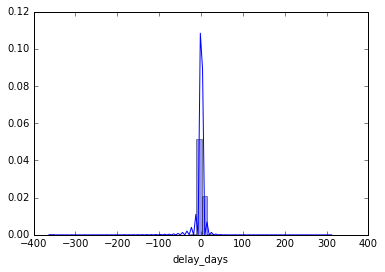

In [101]:
#graph the distribution of delays
sns.distplot(df_v_LA.delay_days)

In [116]:
mean_delay = df_v_LA.delay_days.mean()
sd_delay = df_v_LA.delay_days.std()

In [118]:
mean_delay, sd_delay

(0.85475922636287927, 6.10928034967242)

In [137]:
#standard deviations from the mean
a = mean_delay - (3 * sd_delay)
b = mean_delay + (3 * sd_delay)
a,b

(-17.473081822654379, 19.182600275380139)

** Get the number and percent of delays that are within approximately 3 standard deviations of the mean delay days **

In [148]:
delays_20_days = df_v_LA[ (df_v_LA.delay_days <= -20) | (df_v_LA.delay_days >= 20) ]

In [149]:
#number and percent of delays 100 days prior or after estimated arrival date
print len(delays_20_days)
print round(len(delays_20_days)/(len(df_v_LA) * 1.0),4)

27237
0.0075


** Create a new dataframe that only includes vessels with arrivals within 20 days prior or after estimated arrival date **

In [150]:
#set up the new dataframe
df_v_LA20 = df_v_LA[ (df_v_LA.delay_days > -20) & (df_v_LA.delay_days < 20) ]

** View the foreign port of lading information **

In [153]:
#number of trading ports that appear in the datset as foreign port of lading where Los Angeles
#or Long Beach are the port of unlading
len(df_v_LA20.foreign_port_of_lading.unique())

355

In [163]:
#view top 5 ports sorted by number of observations
df_v_LA20[['foreign_port_of_lading','port_of_unlading','identifier']].groupby(
    ['foreign_port_of_lading','port_of_unlading'], as_index = False).count().sort_values(
    'identifier',ascending = False).head()

,foreign_port_of_lading,port_of_unlading,identifier
178103,"Shanghai ,China (Mainland)","Long Beach, California",380693.0
230957,"Yantian,China (Mainland)","Los Angeles, California",364451.0
178106,"Shanghai ,China (Mainland)","Los Angeles, California",271777.0
230954,"Yantian,China (Mainland)","Long Beach, California",246659.0
66242,"Hong Kong,Hong Kong","Los Angeles, California",158276.0


In [164]:
#get last word of port names
#df_v_LA20.foreign_port_of_lading.str.split().str.get(-1)

** This is consistent with the top ports in China, and to simplify this analysis it will focus only on shipping between Shanghai, China (Mainland) and Los Angeles/ Long Beach ** 

** Subset the dataframe to include only observations where the foreign port of unlading is 'Shanghai, China (Mainland)' **

In [167]:
#create a new subset
df_v_LA_SH = df_v_LA20[df_v_LA20.foreign_port_of_lading == 'Shanghai ,China (Mainland)']
df_v_LA_SH.shape

(652470, 24)

In [173]:
#check that only one port shows up
len(df_v_LA_SH.foreign_port_of_lading.unique())

1

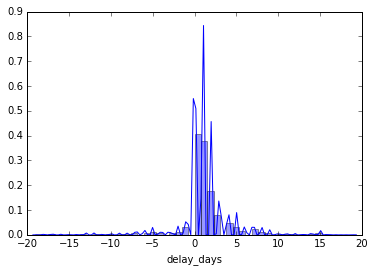

In [168]:
#graph the distribution of delays
sns.distplot(df_v_LA_SH.delay_days)

** Some vessels have inconsistent spelling, use Levenshtein to clean **

In [205]:
Levenshtein.ratio('hello world', 'hello')

0.625

In [207]:
#https://stackoverflow.com/questions/16924421/pandas-apply-function-to-current-row-against-all-other-rows
ratings = pd.DataFrame({
    'article_a':[1,1,0,0],
    'article_b':[1,0,0,0],
    'article_c':[1,0,0,0],
    'article_d':[0,0,0,1],
    'article_e':[0,0,0,1]
},index=['Alice','Bob','Carol','Dave'])

In [237]:
ratings2 = pd.DataFrame({
    'article_a':['red','tred','thread','five'],
},index=['Alice','Bob','Carol','Dave'])

In [238]:
ratings2

,article_a
Alice,red
Bob,tred
Carol,thread
Dave,five


In [247]:
#ratings2.iloc[0,0]
Levenshtein.ratio('red','five')
ratings2.iloc[3,0], ratings2.T.iloc[0,1]
#Levenshtein.ratio(ratings2.iloc[3,0],ratings2.T.iloc[0,3])

('five', 'tred')

** Identify Vessel Voyages **  
group vessels by dates within d days of each other - assume longer than d days is a different voyage

In [169]:
#set d to 15 since voyages are roughly a month apart
d = 15

In [170]:
#sort by vessel,then by estimated arrival date, then by port_of_unlading
df_v_LA_SH = df_v_LA_SH.sort_values(['vessel_name','estimated_arrival_date'])
df_v_LA_SH.head(10)

,identifier,trade_update_date,run_date,vessel_name,port_of_unlading,estimated_arrival_date,foreign_port_of_lading,record_status_indicator,place_of_receipt,port_of_destination,...,container_number,description_sequence_number,piece_count,description_text,carrier,day_of_week_est,day_of_week_act,month_est,month_act,delay_days
774240,2014052738644,2014-05-09,2014-05-27,9294800,"Long Beach, California",2014-05-25,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,KKFU6995770,1,1,LIGHTING,9294800,6,0,5,5,1
7714174,2014022133145,2014-01-28,2014-02-21,9337937,"Los Angeles, California",2014-02-14,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,CCLU4638464,1,2148,SEALED BEAM,9337937,4,3,2,2,6
7714175,2014022133145,2014-01-28,2014-02-21,9337937,"Los Angeles, California",2014-02-14,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,CCLU4835057,1,1440,SEALED BEAM,9337937,4,3,2,2,6
7714176,2014022133145,2014-01-28,2014-02-21,9337937,"Los Angeles, California",2014-02-14,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,CCLU4886033,1,1560,SEALED BEAM,9337937,4,3,2,2,6
2726421,2014022134266,2014-01-29,2014-02-21,9337937,"Los Angeles, California",2014-02-15,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,CCLU6786521,1,75,DRESSER UNIT/NIGHTSTAND/DESK UNIT,9337937,5,3,2,2,5
2726422,2014022134266,2014-01-29,2014-02-21,9337937,"Los Angeles, California",2014-02-15,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,CCLU6862853,1,70,DRESSER UNIT/NIGHTSTAND/DESK UNIT,9337937,5,3,2,2,5
2726423,2014022134266,2014-01-29,2014-02-21,9337937,"Los Angeles, California",2014-02-15,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,CCLU7054063,1,75,DRESSER UNIT/NIGHTSTAND/DESK UNIT,9337937,5,3,2,2,5
2726424,2014022134266,2014-01-29,2014-02-21,9337937,"Los Angeles, California",2014-02-15,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,CCLU7434931,1,70,DRESSER UNIT/NIGHTSTAND/DESK UNIT,9337937,5,3,2,2,5
2726425,2014022134266,2014-01-29,2014-02-21,9337937,"Los Angeles, California",2014-02-15,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,DFSU6069991,1,70,DRESSER UNIT/NIGHTSTAND/DESK UNIT,9337937,5,3,2,2,5
2726426,2014022134266,2014-01-29,2014-02-21,9337937,"Los Angeles, California",2014-02-15,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,GESU5789200,1,70,DRESSER UNIT/NIGHTSTAND/DESK UNIT,9337937,5,3,2,2,5


In [171]:
#groupby vessel_name and shift the estimated_arrival_date down one row to compare current to prior
df_v_LA_SH['prior_est_arr_date'] = df_v_LA_SH.groupby(['vessel_name'])['estimated_arrival_date'].shift()

In [174]:
#view results
df_v_LA_SH.head()

,identifier,trade_update_date,run_date,vessel_name,port_of_unlading,estimated_arrival_date,foreign_port_of_lading,record_status_indicator,place_of_receipt,port_of_destination,...,description_sequence_number,piece_count,description_text,carrier,day_of_week_est,day_of_week_act,month_est,month_act,delay_days,prior_est_arr_date
774240,2014052738644,2014-05-09,2014-05-27,9294800,"Long Beach, California",2014-05-25,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,1,1,LIGHTING,9294800,6,0,5,5,1,NaT
7714174,2014022133145,2014-01-28,2014-02-21,9337937,"Los Angeles, California",2014-02-14,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,1,2148,SEALED BEAM,9337937,4,3,2,2,6,NaT
7714175,2014022133145,2014-01-28,2014-02-21,9337937,"Los Angeles, California",2014-02-14,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,1,1440,SEALED BEAM,9337937,4,3,2,2,6,2014-02-14
7714176,2014022133145,2014-01-28,2014-02-21,9337937,"Los Angeles, California",2014-02-14,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,1,1560,SEALED BEAM,9337937,4,3,2,2,6,2014-02-14
2726421,2014022134266,2014-01-29,2014-02-21,9337937,"Los Angeles, California",2014-02-15,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,1,75,DRESSER UNIT/NIGHTSTAND/DESK UNIT,9337937,5,3,2,2,5,2014-02-14


In [175]:
#check if the prior date is within d days of the prior estimated arrival date
df_v_LA_SH['same_as_prior'] = df_v_LA_SH.estimated_arrival_date <= (df_v_LA_SH.prior_est_arr_date + timedelta(days=d))

In [176]:
#for all false in same as prior enter 1 otherwise enter 0, then implement a running sum to get the voyage numbers
df_v_LA_SH['new_voyage'] = ~df_v_LA_SH.same_as_prior * 1

In [177]:
#implement a running sum
df_v_LA_SH['voyage'] = df_v_LA_SH.groupby('vessel_name')['new_voyage'].cumsum()

In [178]:
df_v_LA_SH.sort_values('voyage',ascending = False)

,identifier,trade_update_date,run_date,vessel_name,port_of_unlading,estimated_arrival_date,foreign_port_of_lading,record_status_indicator,place_of_receipt,port_of_destination,...,carrier,day_of_week_est,day_of_week_act,month_est,month_act,delay_days,prior_est_arr_date,same_as_prior,new_voyage,voyage
7942241,2014121671494,2014-12-01,2014-12-16,R J PFEIFFER,"Long Beach, California",2014-12-14,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,R,6,0,12,12,1,2014-12-14,True,0,10
7942231,2014121670335,2014-12-01,2014-12-16,R J PFEIFFER,"Long Beach, California",2014-12-14,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,R,6,0,12,12,1,2014-12-14,True,0,10
7656019,2014121671836,2014-12-01,2014-12-16,R J PFEIFFER,"Long Beach, California",2014-12-14,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,R,6,0,12,12,1,2014-12-14,True,0,10
7656020,2014121671836,2014-12-01,2014-12-16,R J PFEIFFER,"Long Beach, California",2014-12-14,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,R,6,0,12,12,1,2014-12-14,True,0,10
7656021,2014121671836,2014-12-01,2014-12-16,R J PFEIFFER,"Long Beach, California",2014-12-14,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,R,6,0,12,12,1,2014-12-14,True,0,10
7656022,2014121671836,2014-12-01,2014-12-16,R J PFEIFFER,"Long Beach, California",2014-12-14,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,R,6,0,12,12,1,2014-12-14,True,0,10
7657786,2014121838649,2014-12-01,2014-12-18,R J PFEIFFER,"Long Beach, California",2014-12-14,"Shanghai ,China (Mainland)",Amended,"SHANGHAI,CN",NaN,...,R,6,0,12,12,1,2014-12-14,True,0,10
7941852,2014121653718,2014-12-10,2014-12-16,R J PFEIFFER,"Long Beach, California",2014-12-14,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,R,6,0,12,12,1,2014-12-14,True,0,10
7942229,2014121670015,2014-12-04,2014-12-16,R J PFEIFFER,"Long Beach, California",2014-12-14,"Shanghai ,China (Mainland)",New,"SHANGHAI, CHINA",NaN,...,R,6,0,12,12,1,2014-12-14,True,0,10
7942230,2014121670086,2014-12-01,2014-12-16,R J PFEIFFER,"Los Angeles, California",2014-12-14,"Shanghai ,China (Mainland)",New,"SHANGHAI, CHINA",NaN,...,R,6,0,12,12,1,2014-12-14,True,0,10


** Explore what voyages looks like for one vessel **

In [180]:
len(df_v_LA_SH.vessel_name.unique())

439

In [198]:
#look for a vessel with a lot of voyages and get the number of voyages per vessel and sort by number of voyages
df_v_LA_SH[['vessel_name','voyage']].groupby('vessel_name').max().sort_values('voyage',ascending = False).head()

,voyage
vessel_name,
R J PFEIFFER,10.0
RJ PFEIFFER,10.0
R.J. PFEIFFER,9.0
MAUNAWILI,9.0
BALTIMORE BRIDGE,9.0


In [202]:
list(df_v_LA_SH.vessel_name.unique())

['9294800',
 '9337937',
 '9364992',
 '9399014',
 '9630365',
 '9645865',
 'AAL DALIAN',
 'AAL MELBOURNE',
 'ADRIAN MAERSK',
 'ALBERT MAERSK',
 'AMBASSADOR BRIDGE',
 'ANNA MAERSK',
 'ANTON SCHULTE',
 'ANTONIA SCHULTE',
 'APL   CHINA',
 'APL  CHINA',
 'APL  FLORIDA',
 'APL  WASHINGTON',
 'APL AUSTRIA',
 'APL CALIFORNIA',
 'APL CHINA',
 'APL COLORADO',
 'APL ENGLAND',
 'APL FLORIDA',
 'APL HAMBURG',
 'APL HOLIAND',
 'APL HOLLAND',
 'APL INDIA',
 'APL JAPAN',
 'APL KOREA',
 'APL NEW JERSEY',
 'APL NORWAY',
 'APL PHILIPPINES',
 'APL RIYADH',
 'APL SAVANNAH',
 'APL SCOTLAND',
 'APL SINGAPORE',
 'APL THAILAND',
 'APL TOKYO',
 'APL TURKEY',
 'APL WASHINGTON',
 'ARNOLD MAERSK',
 'ARTHUR MAERSK',
 'ATLANTA EXPRESS',
 'ATLANTIC DAWN',
 'AUGUSTA KONTOR',
 'BAI CHAY BRIDGE',
 'BAICHAY BRIDGE',
 'BALITMORE BRIDGE',
 'BALTIMORE BRIDGE',
 'BALTIMORE?BRIDGE',
 'BANGKOK BRIDGE',
 'BAY BRIDGE',
 'BAY CHAY BRIDGE',
 'BEAR MOUNTAIN BRIDG',
 'BEAR MOUNTAIN BRIDGE',
 'BOSTON EXPRESS',
 'BREMEN BRIDGE',
 'BROK

** There are multiple spellings of some ship names **

In [199]:
vessel1 = df_v_LA_SH[df_v_LA_SH.vessel_name == 'R J PFEIFFER'][['vessel_name','foreign_port_of_lading','port_of_unlading',
                                                             'voyage','estimated_arrival_date','actual_arrival_date',
                                                            'delay_days']]

In [201]:
df_v_LA_SH[df_v_LA_SHA_SH.vessel_name == 'R. J. PFEIFFER']

,identifier,trade_update_date,run_date,vessel_name,port_of_unlading,estimated_arrival_date,foreign_port_of_lading,record_status_indicator,place_of_receipt,port_of_destination,...,carrier,day_of_week_est,day_of_week_act,month_est,month_act,delay_days,prior_est_arr_date,same_as_prior,new_voyage,voyage
9428962,2014020740301,2014-01-20,2014-02-07,R. J. PFEIFFER,"Long Beach, California",2014-02-03,"Shanghai ,China (Mainland)",Amended,SHANGHAI,NaN,...,R.,0,0,2,2,0,NaT,False,1,1
4464498,2014041541969,2014-03-28,2014-04-15,R. J. PFEIFFER,"Long Beach, California",2014-04-11,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,R.,4,6,4,4,2,2014-02-03,False,1,2
5587602,2014090395585,2014-08-18,2014-09-03,R. J. PFEIFFER,"Long Beach, California",2014-09-01,"Shanghai ,China (Mainland)",New,SHANGHAI,NaN,...,R.,0,6,9,8,-1,2014-04-11,False,1,3


In [185]:
vessel1.sort_values(['voyage','foreign_port_of_lading']).drop_duplicates()
#d = 15 seems reasonable for this vessel

,vessel_name,foreign_port_of_lading,port_of_unlading,voyage,estimated_arrival_date,actual_arrival_date,delay_days
368728,R J PFEIFFER,"Shanghai ,China (Mainland)","Long Beach, California",1,2014-12-22,2014-12-15,-7


** Delay Range by Voyage **  
look at the ranges around delays by voyage - look at examples that have a wide range

In [252]:
#get min and max delay by vessel name and voyage
delay_by_voyage = df_v_LA_SH[['vessel_name','voyage','delay_days']].groupby(['vessel_name','voyage'],as_index=False).agg([min,max])

In [253]:
#reformat columns
delay_by_voyage.columns = ['_'.join(tup).rstrip('_') for tup in delay_by_voyage.columns.values]
delay_by_voyage.reset_index(col_level=1,inplace = True)

In [254]:
#add a delay difference column
delay_by_voyage['delay_diff'] = delay_by_voyage.delay_days_max - delay_by_voyage.delay_days_min

In [255]:
#view shape
delay_by_voyage.shape

(1048, 5)

In [256]:
#see number of rows where the difference between the min and max is greater than 5 days
delay_by_voyage[delay_by_voyage.delay_diff >= 5].shape

(603, 5)

In [258]:
#look at some of the large discrepancies
delay_by_voyage.sort_values('delay_diff', ascending = False)

,vessel_name,voyage,delay_days_min,delay_days_max,delay_diff
351,CSCL SPRING,5,-19,17,36
864,OOCL KUALA LUMPUR,3,-16,19,35
859,OOCL ITALY,7,-16,19,35
369,CSCL YELLOW SEA,4,-15,19,34
463,HANJIN KOREA,3,-19,15,34
472,HANJIN LONG BEACH,7,-19,15,34
342,CSCL BOHAI SEA,1,-19,15,34
457,HANJIN HAMBURG,4,-19,15,34
491,HANJIN NETHERLANDS,5,-19,15,34
867,OOCL OAKLAND,1,-18,16,34


In [259]:
delay_by_voyage[delay_by_voyage.vessel_name == 'CSCL SPRING']

,vessel_name,voyage,delay_days_min,delay_days_max,delay_diff
347,CSCL SPRING,1,-10,10,20
348,CSCL SPRING,2,-16,4,20
349,CSCL SPRING,3,-10,8,18
350,CSCL SPRING,4,-15,7,22
351,CSCL SPRING,5,-19,17,36
352,CSCL SPRING,6,-1,18,19


In [286]:
#view one of the vessels - unique records only
vessel2 = df_v_LA_SH[df_v_LA_SH.vessel_name == 'CSCL SPRING'][['vessel_name','foreign_port_of_lading','port_of_unlading',
                                                             'voyage','consignee_name','shipper_party_name',
                                                               'estimated_arrival_date',
                                                               'actual_arrival_date','record_status_indicator',
                                                               'trade_update_date','run_date','delay_days',
                                                              ]].drop_duplicates()

In [287]:
#check the number of records
vessel2.shape

(5231, 12)

In [295]:
vessel2[300:350]

,vessel_name,foreign_port_of_lading,port_of_unlading,voyage,consignee_name,shipper_party_name,estimated_arrival_date,actual_arrival_date,record_status_indicator,trade_update_date,run_date,delay_days
5121650,CSCL SPRING,"Shanghai ,China (Mainland)","Los Angeles, California",1,DYNAMIC COLORS IMAGES INC,SHANGHAI NEMO INTERNATIONAL,2014-02-01,2014-02-02,Amended,2014-01-20,2014-02-06,1
5124388,CSCL SPRING,"Shanghai ,China (Mainland)","Los Angeles, California",1,COOPER B LINE CORONA PLANT,UNION RES0URCES ENGINEERING CO.LTD,2014-02-01,2014-02-02,Amended,2014-01-16,2014-02-11,1
5406104,CSCL SPRING,"Shanghai ,China (Mainland)","Los Angeles, California",1,SINCLAIR & RUSH INC,TAIZHOU BLONS,2014-02-01,2014-02-02,New,2014-01-15,2014-02-03,1
5406110,CSCL SPRING,"Shanghai ,China (Mainland)","Los Angeles, California",1,SENSOURCE GLOBAL SOURCING LLC,SENSOURCE,2014-02-01,2014-02-02,New,2014-01-15,2014-02-03,1
5406111,CSCL SPRING,"Shanghai ,China (Mainland)","Los Angeles, California",1,"UTI,UNITED STATES,INC.",UTI(CHINA)LIMITED,2014-02-01,2014-02-02,New,2014-01-16,2014-02-03,1
5406129,CSCL SPRING,"Shanghai ,China (Mainland)","Los Angeles, California",1,BASS PRO LLC ATTN DIANE WEBSTER,"WENZHOU SHUANGBAO SHOES CO.,LTD",2014-02-01,2014-02-02,New,2014-01-15,2014-02-03,1
5406147,CSCL SPRING,"Shanghai ,China (Mainland)","Los Angeles, California",1,AMASS INTERNATIONAL GROUP INC.,AMASS INTERNATIONAL GROUP INC.,2014-02-01,2014-02-02,New,2014-01-16,2014-02-03,1
5406148,CSCL SPRING,"Shanghai ,China (Mainland)","Los Angeles, California",1,DURO CORPORATION,"JIANGSU GL METAL PRODUCTS CO.,LTD",2014-02-01,2014-02-02,New,2014-01-16,2014-02-03,1
5406162,CSCL SPRING,"Shanghai ,China (Mainland)","Los Angeles, California",1,"COASTER CO., OF AMERICA, INC","KUNSHAN LEGEND FURNITURE CO.,LTD",2014-02-01,2014-02-02,New,2014-01-16,2014-02-03,1
5406163,CSCL SPRING,"Shanghai ,China (Mainland)","Los Angeles, California",1,24 7 INTERNATIONAL LLC,YUYAO NDA INTERNATIONAL TRADING CO.,2014-02-01,2014-02-02,New,2014-01-16,2014-02-03,1


** The estimated arrival dates appear to be completely random, it's possible they're just putting something in the system because they have to but these aren't dates that anyone relies on **

For each vessel voyage, get:
- most common estimated arrival date / number of unique estimated arrival dates
- most common actual arrival date/ number of unique arrival dates
- average delay days / range of delay days
- number of observations / number of shippers / number of consignees

** Save the subset of the file **

In [297]:
#output the file so it can be easily imported
df_v_LA_SH.to_pickle('2014_data_LA_SH.pkl')